https://www.kaggle.com/code/cyrillecervantes/arrhythmia-detection-using-transformer#Transformer-Model

In [2]:
import torch
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get current CUDA device index (if available)
if torch.cuda.is_available():
    print("Current CUDA device index:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA devices found.")

PyTorch version: 2.5.0+cu118
CUDA available: True
Current CUDA device index: 0
CUDA device name: NVIDIA GeForce RTX 3070


In [3]:
import pandas as pd
import numpy as np
import copy

from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.utils import class_weight, resample
from keras.utils import to_categorical
from keras.metrics import Precision,Recall
from keras import Model

import matplotlib.pyplot as plt

import os
dataframes = {}
directory_path = 'Heartbeat_Dataset'
all_files = os.listdir(directory_path)

for file in os.listdir(directory_path):
    if file.endswith('.csv'):
        file_path = os.path.join(directory_path, file)
        # Remove the .csv extension for the DataFrame name
        df_name = os.path.splitext(file)[0]
        dataframes[df_name] = pd.read_csv(file_path, header= None)


In [65]:
print(dataframes.keys())

dict_keys(['mitbih_test', 'mitbih_train', 'ptbdb_abnormal', 'ptbdb_normal'])


In [32]:
train_df = dataframes['mitbih_train']


In [67]:
train_df.shape

(87554, 188)

In [73]:
train_df.shape

(87554, 188)

In [39]:
print(f"Number of samples in train data: {train_df.shape[0]}")

# Check distribution of classes in test and train sets
print("Train dataset class distribution")

train_df.iloc[:, -1] = train_df.iloc[:, -1].astype(int)
print(train_df.iloc[:, -1].value_counts())

Number of samples in train data: 87554
Train dataset class distribution
187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


In [9]:
labels = {
    0.0: "N",
    1.0: "S",
    2.0: "V",
    3.0: "F",
    4.0: "Q"
}

In [ ]:
# Rename the values in the last column using the labels dictionary
train_df.iloc[:, -1] = train_df.iloc[:, -1].replace(labels)
train_counts = train_df.iloc[:, -1].value_counts()
print(train_counts)


187
N    72471
Q     6431
V     5788
S     2223
F      641
Name: count, dtype: int64


C:\Users\randa\AppData\Local\Temp\ipykernel_18512\334857607.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        N
1        N
2        N
3        N
4        N
        ..
87549    Q
87550    Q
87551    Q
87552    Q
87553    Q
Name: 187, Length: 87554, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train_df.iloc[:, -1] = train_df.iloc[:, -1].replace(labels)


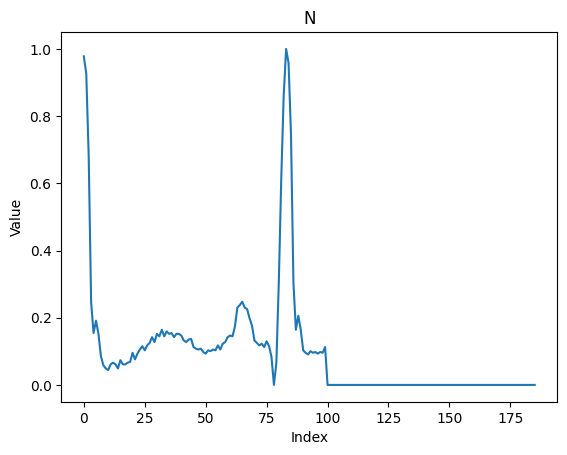

In [ ]:
# Show the plot of the ECG
fig, ax = plt.subplots() 

ax.plot(train_df.iloc[0, :186])
ax.set_title(train_df.iloc[0, 187]) 
ax.set_xlabel("Index")
ax.set_ylabel("Value")


plt.show()

# CNN model

In [12]:
x_data = train_df.iloc[:,:187]
y_label = train_df.iloc[:,-1]

In [ ]:
class CNN1D(nn.Module):
    def __init__(self, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3)
        
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * self._get_conv_output_size(187), 256) 
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def _get_conv_output_size(self, input_length):
        output_length = input_length
        
        for _ in range(3):  # 3 convolutional layers
            output_length = (output_length - 2) // 2  # After conv and pooling

        return output_length

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x)))  
        x = self.flatten(x)
        x = F.relu(self.fc1(x))  
        x = self.dropout(x) 
        x = self.fc2(x)  
        return x

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
label_encoder = LabelEncoder()
  # Encode labels without replacement
y = label_encoder.fit_transform(y_label)
num_classes = len(label_encoder.classes_)  
y = np.eye(num_classes)[y] 


X_train, X_test, y_train, y_test = train_test_split(x_data, y, test_size=0.2, random_state=42)


X_train = np.expand_dims(X_train, axis=1)  
X_test = np.expand_dims(X_test, axis=1)    

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float() 
X_test_tensor = torch.tensor(X_test).float() 
y_train_tensor = torch.tensor(y_train).long() 
y_test_tensor = torch.tensor(y_test).long()   

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
print(y_train.size)

350215


In [16]:
print(len(label_encoder.classes_))

5


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(label_encoder.classes_)
model = CNN1D(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters())


train_acc = []  
test_acc = []
EPOCHS = 20 # Increase this if needed
patience = 3  
best_loss = float('inf')  
patience_counter = 0  

# Training loop
for epoch in range(EPOCHS):
    model.train() 
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available

        optimizer.zero_grad() 
        outputs = model(inputs)  
        loss = criterion(outputs, labels.argmax(dim=1)) 
        loss.backward() 
        optimizer.step()  

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels.argmax(dim=1)).sum().item()

    # Compute and store training accuracy for the epoch
    train_accuracy = correct_train / total_train
    train_acc.append(train_accuracy)

    print(f'Epoch [{epoch + 1}/{EPOCHS}], Loss: {running_loss / len(train_loader):.4f}, Training Accuracy: {train_accuracy:.4f}')

    # Evaluate the model after each epoch
    model.eval()
    with torch.no_grad():
        correct_test = 0
        total_test = 0
        validation_loss = 0.0 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available
            outputs = model(inputs)  
            loss = criterion(outputs, labels.argmax(dim=1)) 
            validation_loss += loss.item()  

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels.argmax(dim=1)).sum().item()

        accuracy = correct_test / total_test  # Calculate test accuracy
        test_acc.append(accuracy)  # Store accuracy for this epoch
        avg_validation_loss = validation_loss / len(test_loader)
        print(f'Epoch [{epoch + 1}/{EPOCHS}], Test Accuracy: {accuracy:.4f}')

        if avg_validation_loss < best_loss:
            best_loss = avg_validation_loss  
            patience_counter = 0  
            # torch.save(model.state_dict(), 'best_model.pth') 
        else:
            patience_counter += 1  
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs.')
                break  

# Create an array for epoch indices
# epoch_indices = np.arange(EPOCHS)



Epoch [1/20], Loss: 0.2140, Training Accuracy: 0.9416
Epoch [1/20], Test Accuracy: 0.9693
Epoch [2/20], Loss: 0.1078, Training Accuracy: 0.9709
Epoch [2/20], Test Accuracy: 0.9775
Epoch [3/20], Loss: 0.0849, Training Accuracy: 0.9760
Epoch [3/20], Test Accuracy: 0.9807
Epoch [4/20], Loss: 0.0724, Training Accuracy: 0.9795
Epoch [4/20], Test Accuracy: 0.9814
Epoch [5/20], Loss: 0.0627, Training Accuracy: 0.9819
Epoch [5/20], Test Accuracy: 0.9830
Epoch [6/20], Loss: 0.0558, Training Accuracy: 0.9838
Epoch [6/20], Test Accuracy: 0.9832
Epoch [7/20], Loss: 0.0505, Training Accuracy: 0.9848
Epoch [7/20], Test Accuracy: 0.9835
Epoch [8/20], Loss: 0.0452, Training Accuracy: 0.9859
Epoch [8/20], Test Accuracy: 0.9846
Epoch [9/20], Loss: 0.0426, Training Accuracy: 0.9868
Epoch [9/20], Test Accuracy: 0.9854
Epoch [10/20], Loss: 0.0388, Training Accuracy: 0.9881
Epoch [10/20], Test Accuracy: 0.9854
Epoch [11/20], Loss: 0.0360, Training Accuracy: 0.9886
Epoch [11/20], Test Accuracy: 0.9865
Epoch 

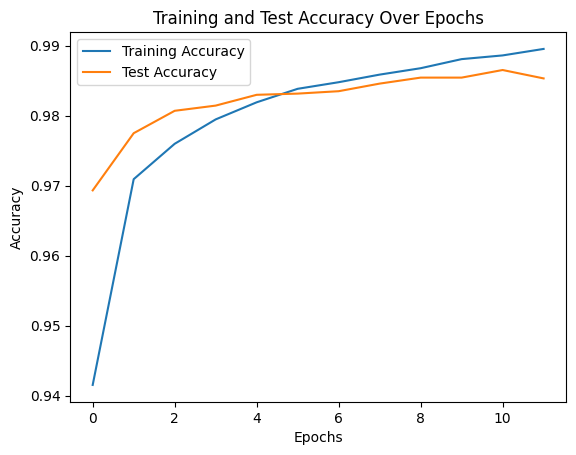

In [18]:
import matplotlib.pyplot as plt


num_epochs = min(len(train_acc), len(test_acc))

plt.figure()
plt.plot(np.arange(num_epochs), train_acc[:num_epochs], label='Training Accuracy')
plt.plot(np.arange(num_epochs), test_acc[:num_epochs], label='Test Accuracy')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()

In [19]:
model_path = "./model/cnn_model2.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to ./model/cnn_model2.pth


In [ ]:
loaded_model = CNN1D(num_classes).to(device)  # Reinitialize model with the same architecture
loaded_model.load_state_dict(torch.load(model_path, weights_only=True))

print("Model loaded successfully.")

sample_inputs = X_test_tensor[:20]  # Take the first 20 samples
sample_inputs = sample_inputs.to(device) 

with torch.no_grad():
    outputs = loaded_model(sample_inputs)
    _, predicted_classes = torch.max(outputs, 1) 

predicted_labels = label_encoder.inverse_transform(predicted_classes.cpu().numpy())  # Move to CPU for numpy conversion

for i, label in enumerate(predicted_labels):
    print(f"Predicted class for sample {i + 1}: {label}")

Model loaded successfully.
Predicted class for sample 1: N
Predicted class for sample 2: N
Predicted class for sample 3: N
Predicted class for sample 4: N
Predicted class for sample 5: Q
Predicted class for sample 6: N
Predicted class for sample 7: N
Predicted class for sample 8: Q
Predicted class for sample 9: Q
Predicted class for sample 10: N
Predicted class for sample 11: N
Predicted class for sample 12: N
Predicted class for sample 13: N
Predicted class for sample 14: N
Predicted class for sample 15: N
Predicted class for sample 16: N
Predicted class for sample 17: S
Predicted class for sample 18: N
Predicted class for sample 19: N
Predicted class for sample 20: N


# Transformers